# Final Capstone - Machine Learning pipeline for art creation

Generative Adversarial Networks (GANs) are Machine Learning techniques that can learn to mimic a given distribution of data. Here is an implementation of a GAN using Keras. The neural network is composed of two subnetworks, the generator and discriminator. The first neural network is in charge of generating new images from noise and feedback from the second network (no direct interaction with the training set), which classifies arrays of real and generated images, helping the generator tune its weights in order to create every-time-more-similar outputs to the training images.

--------------------

### We begin by installing Tensorflow and Keras, which will be fundamental for the development of the neural networks we will use.

In [ ]:
!pip install tensorflow
!pip install keras

### Now, we build the generative network. This neural network is in charge of the first part of the process, the generation of images which will then be discriminated by the second neural network. At the beginning of the iterations, the network will only output noise, it is through training that the network is able to generate 'realistic' images.

In [ ]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential

#Defines function to generate neural network for generator
def generativeNet():
    #Defines layers of neural network
    generativeModel = Sequential()
    
    #Dense layers create the noise
    generativeModel.add(Dense(256*4*4, input_shape = (100,)))
    generativeModel.add(LeakyReLU())
    generativeModel.add(Reshape((4,4,256)))
    
    #Conv2DTranspose allows to convolve backwards
    generativeModel.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generativeModel.add(LeakyReLU(alpha=0.2))

    generativeModel.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generativeModel.add(LeakyReLU(alpha=0.2))

    generativeModel.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generativeModel.add(LeakyReLU(alpha=0.2))

    generativeModel.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generativeModel)

#Runs function -> creates generative network.
generativeNetwork = generativeNet()

#Prints final structure of generative network
generativeNetwork.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                              

--------------------

### Let us test the generative network, as pointed our before, it will only generate noise before going through any training:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


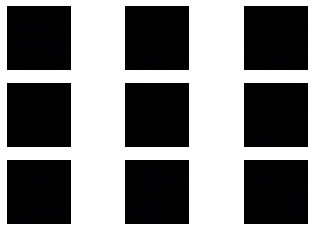

In [ ]:
#Import required libraries
import matplotlib.pyplot as plt
import numpy as np

# Defines random values for future initial input for generative network
def createInput(size):
    X = np.random.randn(100 * size)
    X = X.reshape(size, 100)
    return X

#Defines initial input for discriminative network
def pseudoInput(generativeNetwork, size):
    input = createInput(size)
    #Calls on generative model (defined above)
    X = generativeNetwork.predict(input)
    Y = np.zeros((size, 1))
    return X,Y 

#Runs functions -> creates array with initial outputs
points = 9
X,_ = pseudoInput(generativeNetwork, points)

# Let us see how the initial (without any training) output looks like
for i in range(points):
    plt.subplot(3, 3, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])
    

As expected, the first output from the generative network is just noise.

----------

### Next step will be to develop a discriminative network. This will classify the images into real and not (generated, fakes), and its output will be the base for the generative network's training.

### The discriminator is a normal convolutional neural network. It will take images one by one as input and will output a binary value (real pictures or generated, fake, ones).

In [ ]:
#Imports required libraries
from keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

#Defines function that creates neural network for discrimination
def discriminativeNet():
    #Defines layers for discriminative network
    discriminativeModel = Sequential()
    discriminativeModel.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminativeModel.add(LeakyReLU(alpha=0.2))

    discriminativeModel.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminativeModel.add(LeakyReLU(alpha=0.2))

    discriminativeModel.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminativeModel.add(LeakyReLU(alpha=0.2))

    discriminativeModel.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminativeModel.add(LeakyReLU(alpha=0.2))

    discriminativeModel.add(Flatten())
    discriminativeModel.add(Dropout(0.4))
    discriminativeModel.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    #Uses binary cross-entropy loss function and accuracy as metrics
    discriminativeModel.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminativeModel)

#Runs function -> creates neural network
discriminativeNetwork = discriminativeNet()
discriminativeNetwork.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


-----

### It is time now to prepare the dataset we will use for training. We will use pictures imported from Keras' readily available dataset 'cifar100.' This dataset includes pictures from 100 different categories incluiding ships, trucks, birds, horses, etc. For this implementation we will train the GAN with oak tree pictures, which are indexed by the number 52 (See line 8 underneath):

In [ ]:
#Imports dataset cifar100
from keras.datasets import cifar100

def importImages():
    (Xtrain, Ytrain), (_, _) = cifar100.load_data()

    # Selects oak tree pictures, indexed by the number 52:
    ind = np.where(Ytrain == 52)
    ind = ind[0]
    Xtrain = Xtrain[ind, :,:,:]

    # Normalize data
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

#Prints shape of array
print(importImages().shape)

(500, 32, 32, 3)


In [ ]:
names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [ ]:
names.index('oak_tree')

52

-----------

### Next, we train the discriminator network so that it can discern between real and generated tree pictures. Therefore, we need two functions, one that preprocesses the real images, and one that prepares the fake ones.


In [ ]:
#Imports random library
import random

#Defines function that preprocesses real images for training
def preprocessImages(dataset, points):
    k = np.random.randint(0, dataset.shape[0], points)
    X = dataset[k]
    Y = np.ones((points, 1))
    return X,Y 

#Defines funtion that prepares noise data for training
def preprocessPseudo(points):
    #Note that the fake images must have 
    #the dimensions of the real ones
    X = np.random.rand(32 * 32 * 3 * points) 
    X = -1 + X * 2
    X = X.reshape((points, 32,32,3))
    Y = np.zeros((points, 1))
    return X,Y

In [ ]:
#The function trains the discriminator network
def discTraining(model, dataset, n_iter=20, n_batch = 128):
    #Selects half of the batch
    hBatch = int(n_batch/2)

    for i in range(n_iter):
        X_real, Y_real = preprocessImages(dataset, hBatch)
        _, acc_real = model.train_on_batch(X_real, Y_real)
        #Calculates accuracy
        X_pseudo, Y_pseudo = preprocessPseudo(hBatch)
        _, acc_pseudo = model.train_on_batch(X_pseudo, Y_pseudo)

        print(str(i+1) + ' Real:' + str(acc_real*100) + ', Pseudo:' + str(acc_pseudo*100))

In [ ]:
#Gets images from cifar100
data = importImages()
#Carries training with those pictures
discTraining(discriminativeNetwork, data)

1 Real:59.375, Pseudo:7.8125
2 Real:98.4375, Pseudo:26.5625
3 Real:100.0, Pseudo:81.25
4 Real:95.3125, Pseudo:98.4375
5 Real:98.4375, Pseudo:100.0
6 Real:98.4375, Pseudo:100.0
7 Real:93.75, Pseudo:100.0
8 Real:96.875, Pseudo:100.0
9 Real:96.875, Pseudo:100.0
10 Real:95.3125, Pseudo:100.0
11 Real:93.75, Pseudo:100.0
12 Real:95.3125, Pseudo:100.0
13 Real:98.4375, Pseudo:100.0
14 Real:100.0, Pseudo:100.0
15 Real:100.0, Pseudo:100.0
16 Real:100.0, Pseudo:100.0
17 Real:100.0, Pseudo:100.0
18 Real:98.4375, Pseudo:100.0
19 Real:100.0, Pseudo:100.0
20 Real:98.4375, Pseudo:100.0


### It is instructive to look at the training oak tree pictures. Note that the resolution is considerably low (the pictures are being presented in a lower number of dimensions than the originals), making the images look blurry.

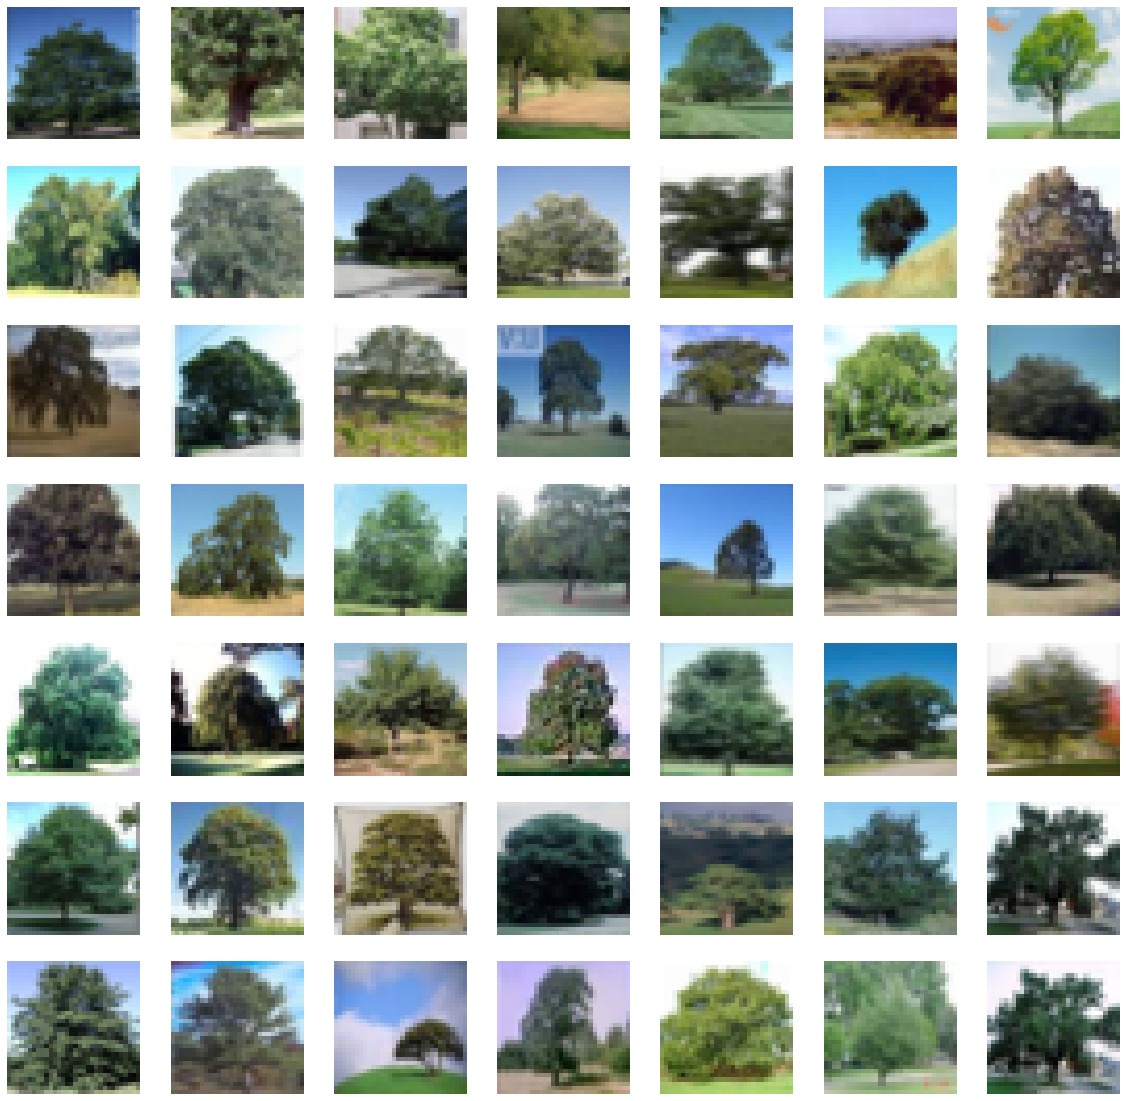

In [ ]:
#Prints 49 of the training pictures
X_gen= data
X_gen = (X_gen+1)/2

plt.figure(figsize=(20, 20))

for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    plt.imshow(X_gen[i])


-----------

### We are ready to put both parts of the algorithm together (generator and discriminator). Here, setting trainable=False allows for the gradient updates of the generator and discriminator to be separate while iterating over the GAN algorithm.

### Furthermore, we will set the finalized GAN as another neural network, and the loss function to be binary cross-entropy.

In [ ]:
#Defines neural network for whole GAN
def GAN(discriminativeN, generativeN):
    discriminativeN.trainable=False
    gan = Sequential()
    gan.add(generativeN)
    gan.add(discriminativeN)
    #Loss function will be binary cross-entropy.
    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

#Runs function -> creates final GAN
gan = GAN(discriminativeNetwork,generativeNetwork)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         1007363   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Now, we create two more functions, one which will save the generated pictures, and another which will save the results from the model. In other words, the second function will save 'checkpoints' for the training process so that the network improves its performance as it iterates.

### Note that the second function creates new arrays of real and fake functions so that the model does not train with the same pictures all the time, decreasing the risk of overfitting.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Saves generated pictures from training
def presentGImages(pseudoData, epoch):

    # Sets values from 0 to 1
    pseudoData = (pseudoData + 1) / 2.0

    for i in range(10):
        plt.imshow(pseudoData[i])
        plt.axis('off')
        name = str(epoch) + '_generated_picture_' + str(i) + '.png'
        plt.savefig(name, bbox_inches='tight')
        plt.close()

In [ ]:
#Saves checkpoints for the model
from datetime import datetime
def assessment(genNet, epoch, hdata):

    # Save the model
    now = datetime.now()
    now = now.strftime("%Y%m%d_%H%M%S")
    name = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
    genNet.save(name)
    
    # Generate new data
    X_real,Y_real = preprocessImages(data, hdata)
    X_gen, Y_gen =  pseudoInput(genNet,hdata)

    # Evaluate the model
    _, acc_real = discriminativeNetwork.evaluate(X_real, Y_real)
    _, acc_gen = discriminativeNetwork.evaluate(X_gen, Y_gen)

    print('Acc Real:' + str(acc_real*100) + '% Acc Gen:' + str(acc_gen*100)+'%')

-------------

### Now that we have all the functions we need we can create a training function for the whole GAN:

In [ ]:
#Creates function for training the GAN
def training(data1, genNet, discNet, epochs, n_batch, begin = 0):
    batchDim = int(data1.shape[0]/n_batch)
    hDataset = int(n_batch/2)

    # Iterating over epochs
    for epoch in range(begin, begin + epochs):
        # Iterate over all batches
        for batch in range(n_batch):

            # Load all the real data
            X_real,Y_real = preprocessImages(data, hDataset)


            #Training the discriminator with real and fake images
            costDReal, _ = discriminativeNetwork.train_on_batch(X_real, Y_real)
            X_gen, Y_gen =  pseudoInput(generativeNetwork,hDataset)

            costDGen, _ = discriminativeNetwork.train_on_batch(X_gen, Y_gen)

            #Generate input images for the GAN
            X_gan = createInput(hDataset)
            Y_gan = np.ones((hDataset, 1))

            #Training the GAN with fake data
            cost_gan = gan.train_on_batch(X_gan, Y_gan)

            # Every 10 epochs we show the results and cost 
    if (epoch+1) % 10 == 0:
        assessment(generativeNetwork, epoch, hDataset)
        presentGImages(X_gen, epoch = epoch)

-------

### Running the training:

In [ ]:
training(data, generativeNetwork, discriminativeNetwork, epochs = 50, n_batch=128, begin = 0)


2/2 [==============================] - 0s 47ms/step - loss: 0.0637 - accuracy: 0.9844
Acc Real:96.875% Acc Gen:98.4375%


### Finally, we print the generated pictures:

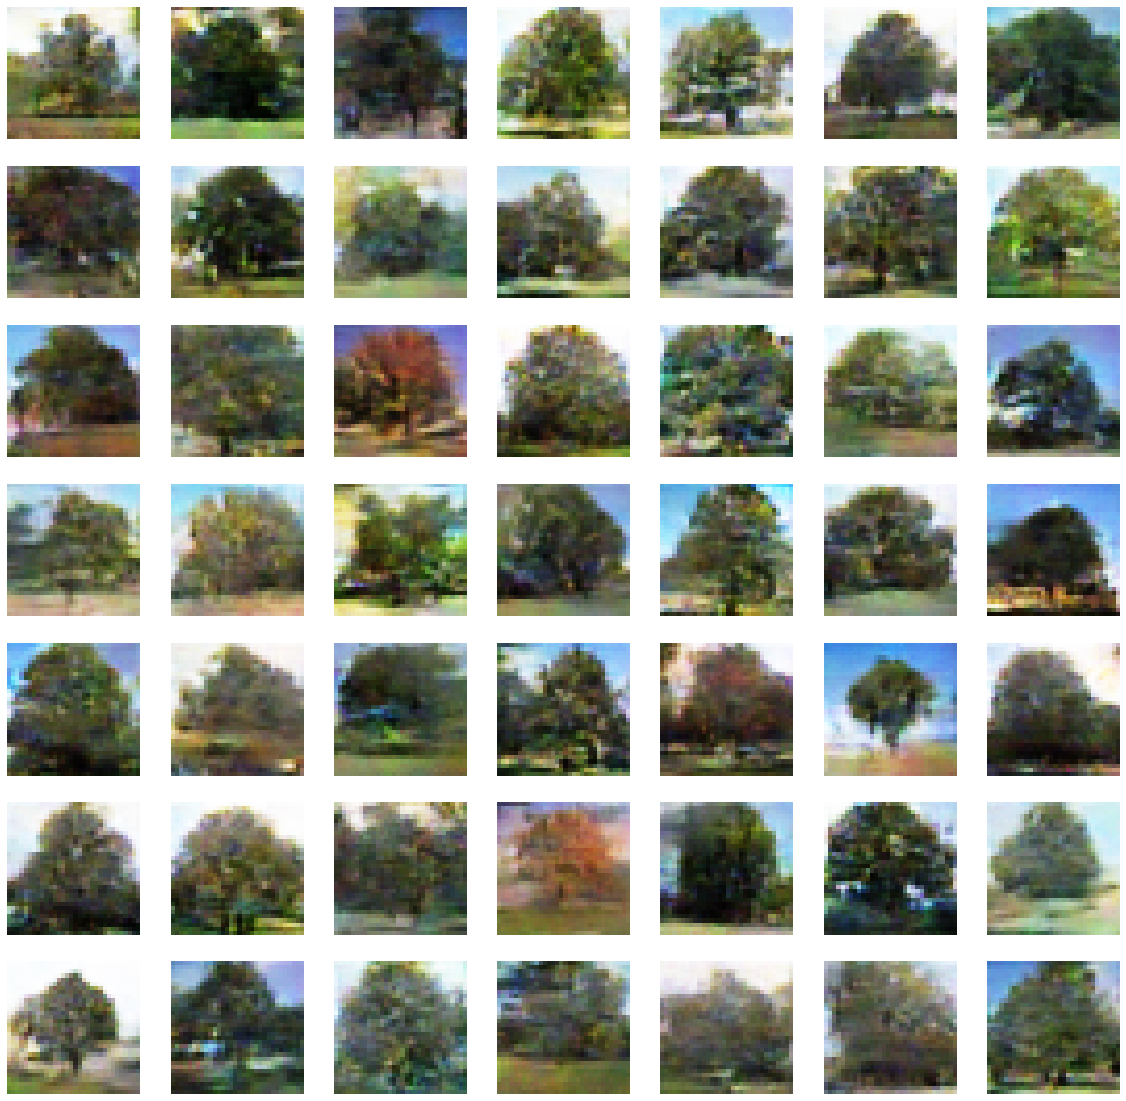

In [ ]:
X_gen, _ = pseudoInput(generativeNetwork=generativeNetwork, size=49)
X_gen = (X_gen+1)/2

plt.figure(figsize=(20, 20))

for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    plt.imshow(X_gen[i])

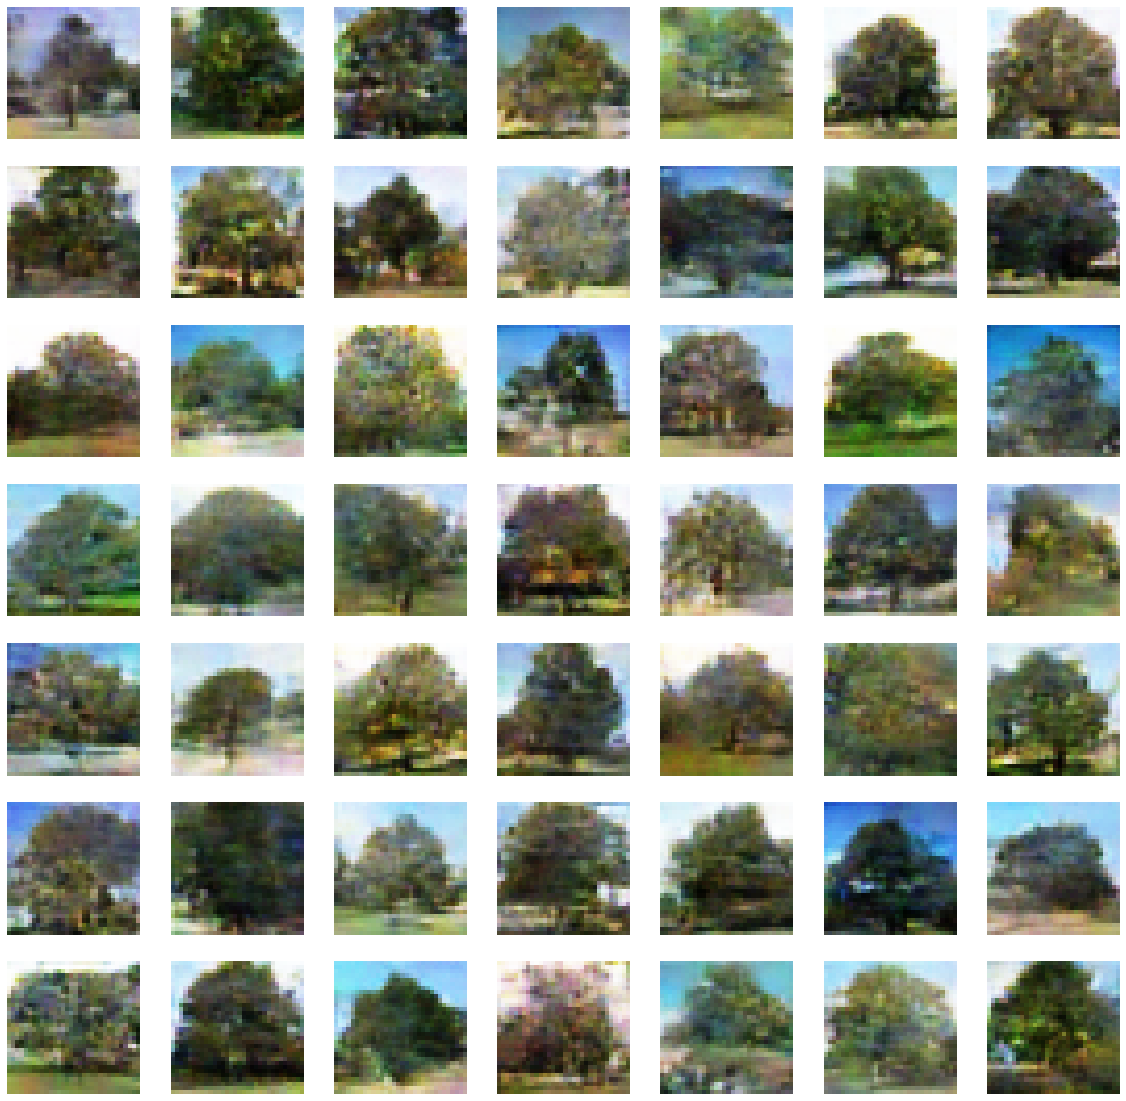

In [ ]:
X_gen, _ = pseudoInput(generativeNetwork=generativeNetwork, size=49)
X_gen = (X_gen+1)/2

plt.figure(figsize=(20, 20))

for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    plt.imshow(X_gen[i])

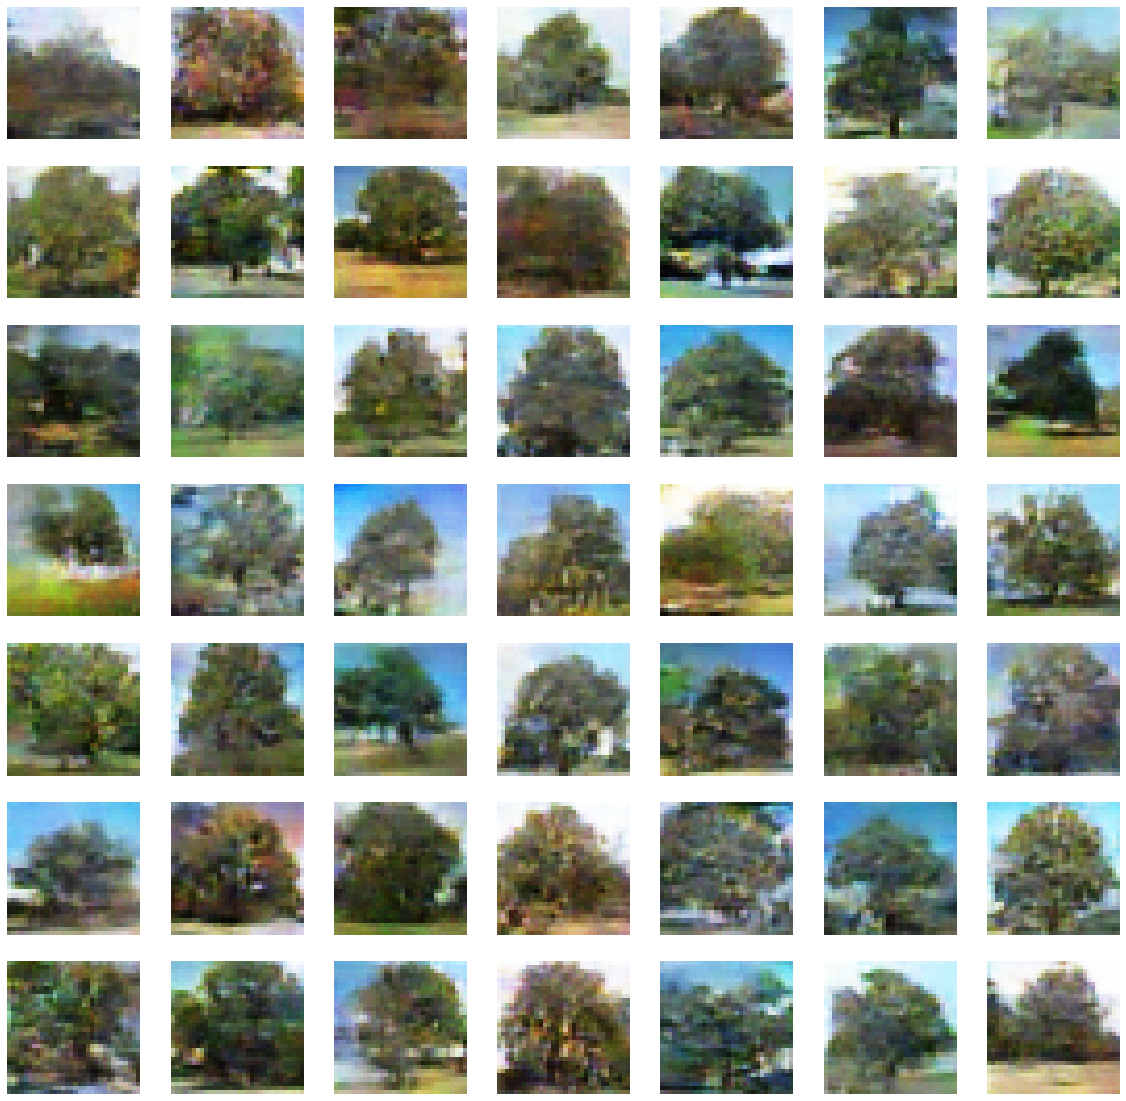

In [ ]:
X_gen, _ = pseudoInput(generativeNetwork=generativeNetwork, size=49)
X_gen = (X_gen+1)/2

plt.figure(figsize=(20, 20))

for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    plt.imshow(X_gen[i])